# Code Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline

In [3]:
!ls -a /content/drive/MyDrive/IT1244_Project/Model_Dataset

LogisticRegression.pkl	mlp.h5	svm_model.pkl  Test_Set.csv  Train_Set.csv  VotingClassifier.pkl


In [4]:
# Standard library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation

## Import Dataset

In [5]:
# Importing data into pandas DataFrame
train_data = pd.read_csv('/content/drive/MyDrive/IT1244_Project/Model_Dataset/Train_Set.csv')
test_data = pd.read_csv('/content/drive/MyDrive/IT1244_Project/Model_Dataset/Test_Set.csv')

## Split Dataset (Train & Test)

In [6]:
# Splitting raw data
train_X_raw, train_y = train_data.drop('class_label', axis=1),  train_data.iloc[:, -1]
headers = list(train_X_raw.columns.values)
test_X_raw, test_y = test_data.drop('class_label', axis = 1), test_data.iloc[:, -1]

## Standardize Dataset

In [7]:
# Standardising data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_X_scaled = pd.DataFrame(scaler.fit_transform(train_X_raw), columns=headers)
test_X_scaled = pd.DataFrame(scaler.transform(test_X_raw), columns=headers)

Unique values in train_y: [0 1]
Unique values in test_y: [0 1]


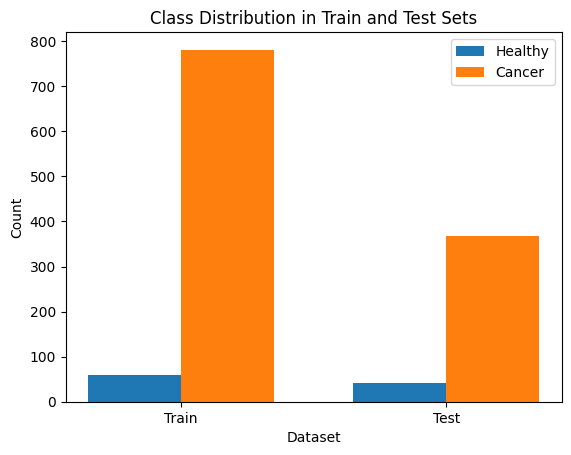

In [8]:
train_y = pd.Series(np.where(train_y == 'cancer', 1, 0))  # Cancer is 1 and healthy is 0
test_y = pd.Series(np.where(test_y == 'cancer', 1, 0))
train_counts = np.bincount(train_y)
test_counts = np.bincount(test_y)
print("Unique values in train_y:", train_y.unique())
print("Unique values in test_y:", test_y.unique())

labels = ['Healthy', 'Cancer']
x = np.arange(2)  # Two sets: Train and Test
fig, ax = plt.subplots()
bar_width = 0.35
healthy_bar = ax.bar(x - bar_width / 2, [train_counts[0], test_counts[0]], bar_width, label='Healthy')
cancer_bar = ax.bar(x + bar_width / 2, [train_counts[1], test_counts[1]], bar_width, label='Cancer')
ax.set_xlabel('Dataset')
ax.set_ylabel('Count')
ax.set_title('Class Distribution in Train and Test Sets')
ax.set_xticks(x)
ax.set_xticklabels(['Train', 'Test'])
ax.legend()

plt.show()

# Exploratory Data Analysis

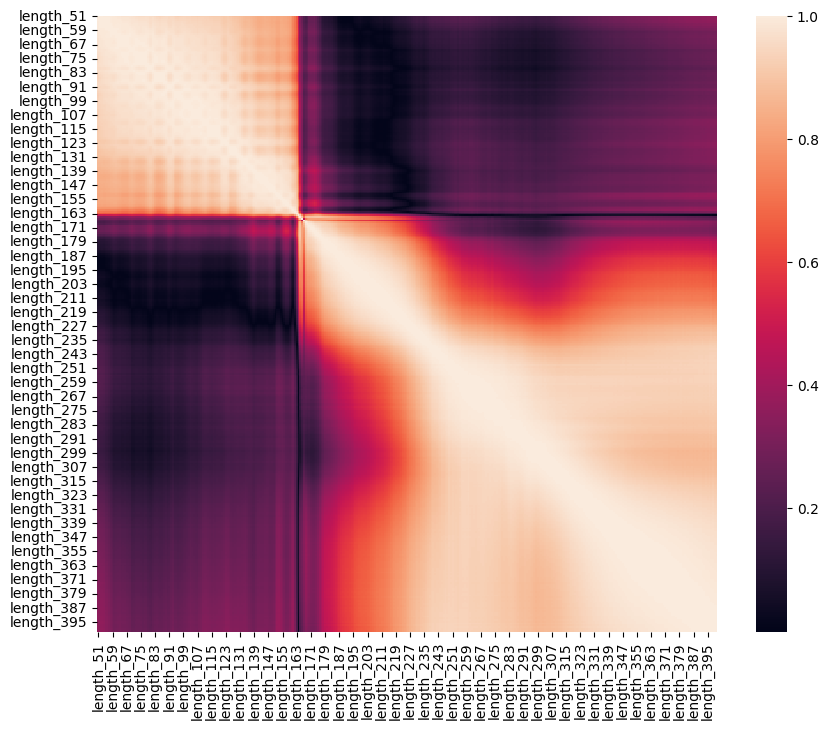

In [9]:
# Correlation matrix
corr = train_X_scaled.corr().abs()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, cmap='rocket', ax=ax)
plt.show()

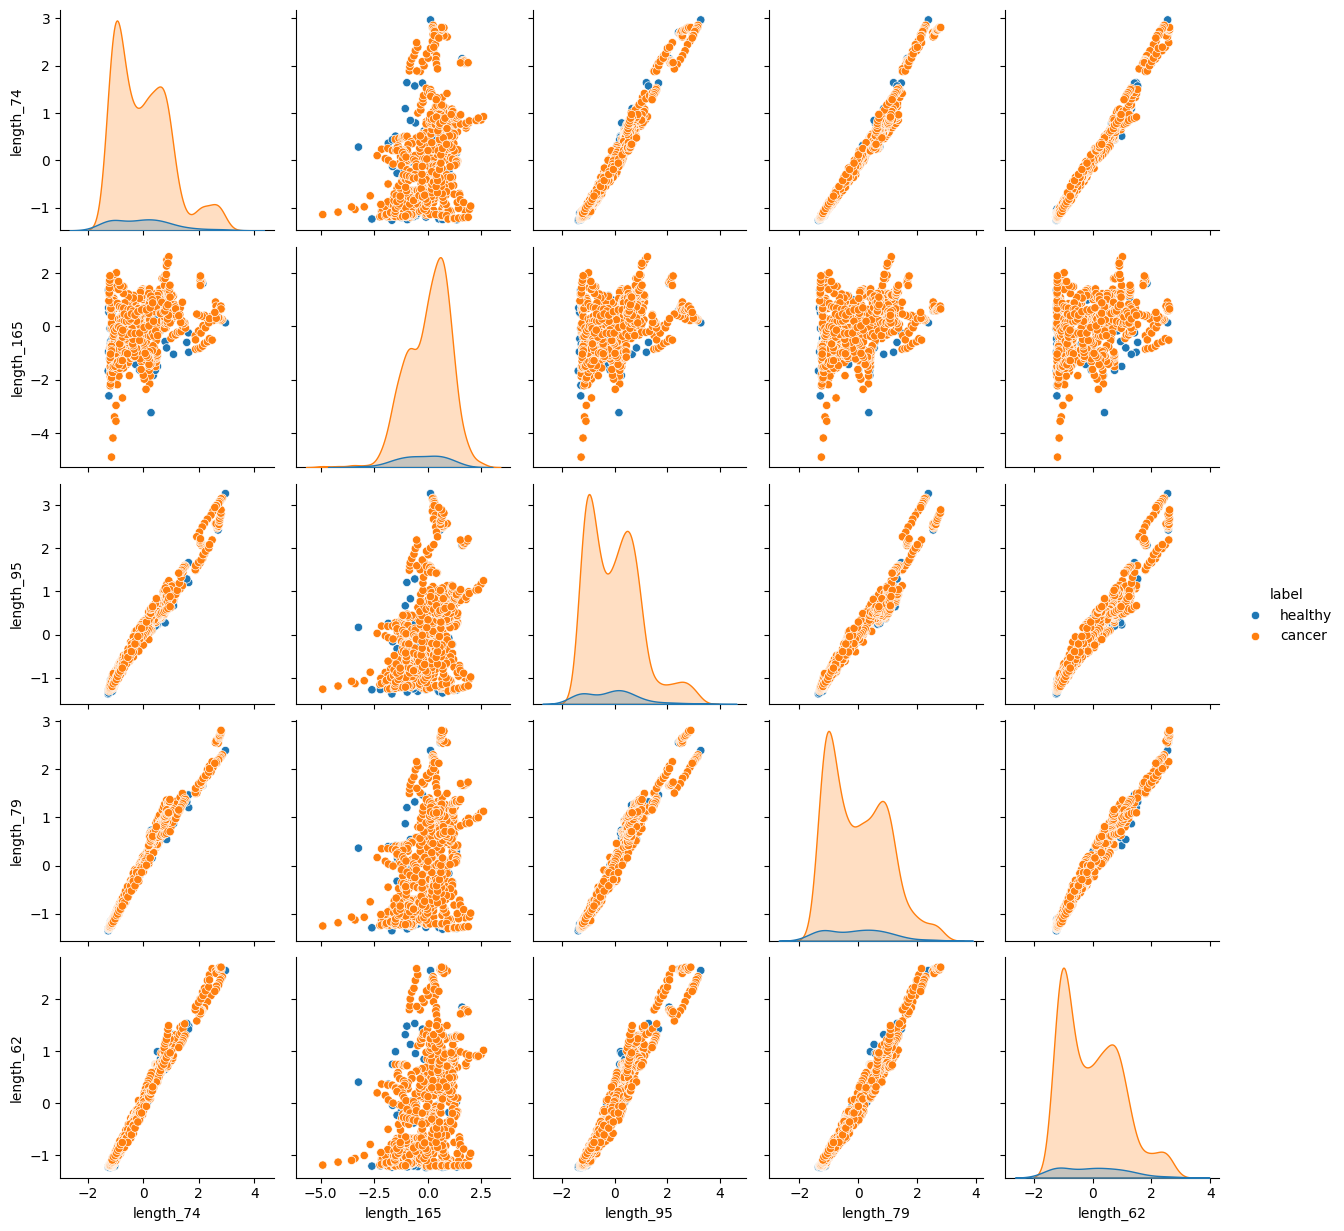

In [10]:
# Set the diagonal to zero so it doesn't affect the average
np.fill_diagonal(corr.values, 0)

# Calculate the average correlation for each feature
avg_corr = corr.mean(axis=1)

# Sort features by average correlation in ascending order
least_correlated_features = avg_corr.sort_values()
top_least_correlated_features = least_correlated_features.head(50).index
selected_features = train_X_scaled[top_least_correlated_features]
selected_features = pd.concat([selected_features, train_y.rename('label')], axis=1)

#Pairplots
# Randomly select 5 features from the least correlated ones
sample_features = np.random.choice(top_least_correlated_features, size=5, replace=False)

# Combine selected features with the label
selected_features = train_X_scaled[sample_features]
selected_features = pd.concat([selected_features, train_y.rename('label')], axis=1)
selected_features['label'] = selected_features['label'].map({0: 'healthy', 1: 'cancer'})

# Plot with color based on label
sns.pairplot(selected_features, hue='label')

# Class Imbalance Handling

## 01. Near Miss

An undersampling technique that selects n-data points that are closest to the minority class, where n is the number of minority samples

In [11]:
from imblearn.under_sampling import NearMiss
from collections import Counter

nm = NearMiss()
X_NM, y_NM = nm.fit_resample(train_X_scaled, train_y)

class_counts = Counter(y_NM)
print(f"Class distribution after resampling: {class_counts}")
print(Counter(train_y))

Class distribution after resampling: Counter({0: 60, 1: 60})
Counter({1: 781, 0: 60})


## 03. Synthetic Minority Oversampling Technique (SMOTE)

SMOTE combines over-sampling of the minority class and under-sampling of the majority class.

Han, Y., Wei, Z., & Huang, G. (2024). An imbalance data quality monitoring based on SMOTE-XGBOOST supported by edge computing. Scientific Reports, 14(1), 10151. https://doi.org/10.1038/s41598-024-60600-x

In [12]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_SM, y_SM = smote.fit_resample(train_X_scaled, train_y)

# Feature Extraction

## 01. Gradient Boosting

Validation AUC-ROC Score: 0.882 (0.037)


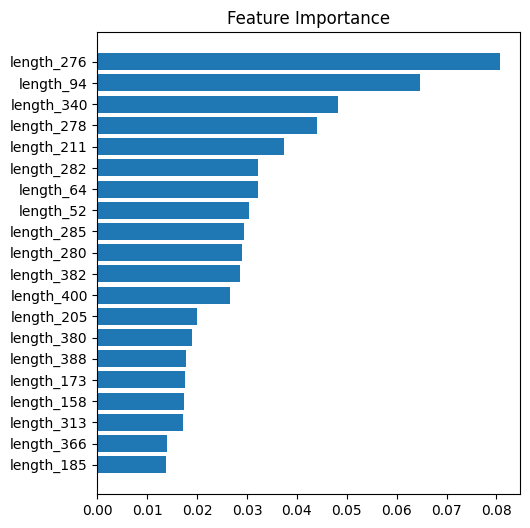

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
# Initialize the GBM model
gbm = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Cross Validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
n_scores = cross_val_score(gbm, train_X_scaled, train_y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
print('Validation AUC-ROC Score: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Train the model
gbm.fit(train_X_scaled, train_y)

# Feature importance based on mean and standard deviation of accumulation of the impurity decrease within each tree
feature_importance = gbm.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

# Plot the top 20 most important features
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos[-20:], feature_importance[sorted_idx][-20:], align="center")
plt.yticks(pos[-20:], np.array(headers)[sorted_idx][-20:])
plt.title("Feature Importance")

data_gbm = train_X_scaled.loc[:, np.array(headers)[sorted_idx][-5:]]
data_gbm_test = test_X_scaled.loc[:, np.array(headers)[sorted_idx][-5:]]
data_gbm['label'] = train_y

Overall, feature selection did not prove useful, as the relative contribution of the top feature was only 0.08. This is likely because, without context about the 350 input features, it is challenging to curate and select the most relevant features for the model.

## 02. Principal Component Analysis (PCA)

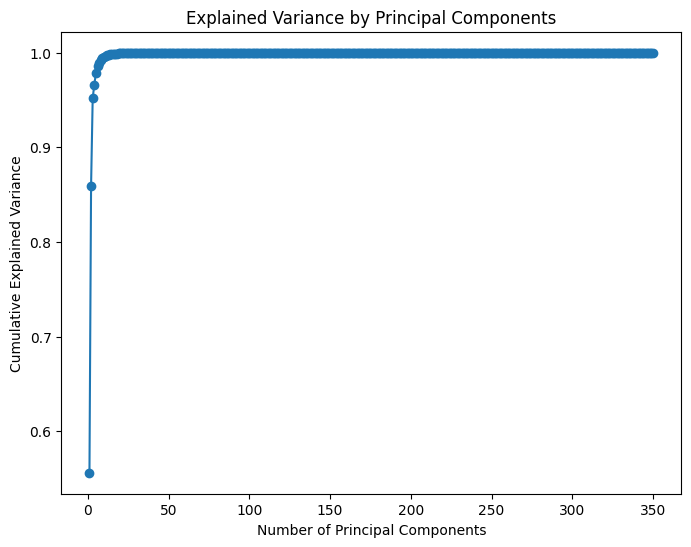

In [14]:
#Principal Component Analysis (Minjun)
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=train_X_scaled.shape[1])
X_pca = pca.fit_transform(train_X_scaled)
explained_variance = pca.explained_variance_ratio_

def plot_explained_variance():
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
    plt.title('Explained Variance by Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

plot_explained_variance()
# Plot shows how many principal components are needed to explain the variance
# within the dataset

In [15]:
# Create a DataFrame for explained variance and cumulative explained variance
explained_variance_df = pd.DataFrame({
    'PC': np.arange(1, len(explained_variance) + 1),
    'Explained Variance Ratio': explained_variance,
    'Cumulative Explained Variance': np.cumsum(explained_variance)
})

# Print the DataFrame
print(explained_variance_df[:20])

    PC  Explained Variance Ratio  Cumulative Explained Variance
0    1                  0.556092                       0.556092
1    2                  0.303287                       0.859379
2    3                  0.092532                       0.951911
3    4                  0.014343                       0.966254
4    5                  0.012026                       0.978280
5    6                  0.007757                       0.986037
6    7                  0.003548                       0.989584
7    8                  0.002588                       0.992172
8    9                  0.001903                       0.994075
9   10                  0.001244                       0.995319
10  11                  0.001136                       0.996455
11  12                  0.000787                       0.997242
12  13                  0.000593                       0.997835
13  14                  0.000471                       0.998306
14  15                  0.000342        

In [16]:
# Identifying loadings
components = pca.components_
loadings_df = pd.DataFrame(components, columns = train_X_raw.columns, index = [f'PC{i+1}' for i in range(components.shape[0])])
print(loadings_df[:20])

      length_51  length_52  length_53  length_54  length_55  length_56  \
PC1    0.027800   0.027846   0.027818   0.027603   0.026646   0.026503   
PC2    0.082051   0.082419   0.082689   0.082895   0.083526   0.083812   
PC3    0.037323   0.038224   0.038145   0.039052   0.039712   0.039226   
PC4    0.007552   0.012726   0.011539   0.013713   0.012063   0.011645   
PC5   -0.079996  -0.084828  -0.086960  -0.089655  -0.090405  -0.089273   
PC6   -0.052825  -0.049701  -0.049621  -0.045150  -0.040816  -0.042117   
PC7   -0.021572  -0.016945  -0.016349  -0.015809  -0.024360  -0.020554   
PC8    0.197865   0.181227   0.169635   0.162735   0.153984   0.152574   
PC9   -0.089506  -0.064219  -0.044894  -0.032835  -0.026378  -0.034151   
PC10   0.061826   0.030644   0.030246   0.016785   0.017443   0.018900   
PC11  -0.019381  -0.014778  -0.017727  -0.015273  -0.005731   0.002705   
PC12  -0.137763  -0.116951  -0.126827  -0.105638  -0.100008  -0.102308   
PC13   0.064929   0.077963   0.063475 

In [17]:
# Generating a dataframe of Principal Components (8)
pca = PCA(n_components = 8)
pca_columns = [f'PC{i+1}' for i in range(8)]
pca_train_X = pd.DataFrame(pca.fit_transform(train_X_scaled), columns = pca_columns)
#Each column represents the reduced Principal component which acts as features in any type of modelling

In [18]:
# Generating a dataframe of Principal Components (test data)
pca_test_X = pd.DataFrame(pca.transform(test_X_scaled), columns = pca_columns)

## 02-1. t-SNE Plot

In [19]:
NM_pca_train_X = pd.DataFrame(pca.fit_transform(X_NM), columns = pca_columns)

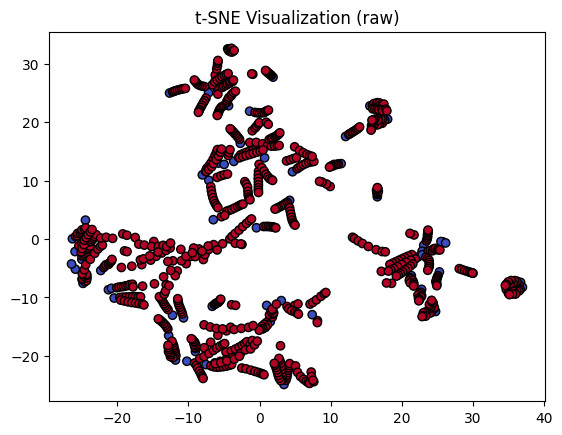

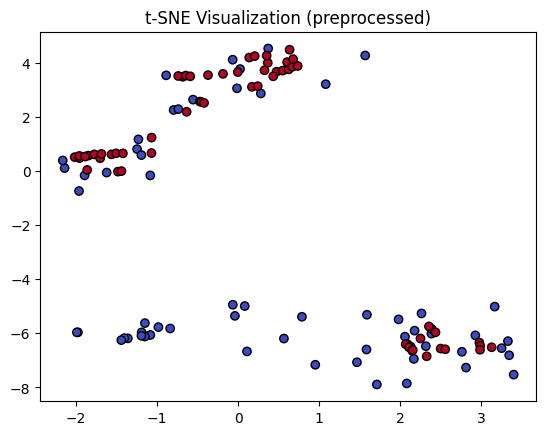

In [20]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_raw_numeric = label_encoder.fit_transform(train_y)
y_preprocessed_numeric = label_encoder.fit_transform(y_NM)

tsne = TSNE(n_components = 2, perplexity = 40, random_state = 42)

X_raw_tsne = tsne.fit_transform(train_X_scaled)
plt.scatter(X_raw_tsne[:, 0], X_raw_tsne[:, 1], c=y_raw_numeric, cmap='coolwarm', edgecolors='k')
plt.title("t-SNE Visualization (raw)")
plt.show()

X_preprocessed_tsne = tsne.fit_transform(NM_pca_train_X)
plt.scatter(X_preprocessed_tsne[:, 0], X_preprocessed_tsne[:, 1], c=y_preprocessed_numeric, cmap='coolwarm', edgecolors='k')
plt.title("t-SNE Visualization (preprocessed)")
plt.show()

## 03. Linear Discriminant Analysis (LDA)

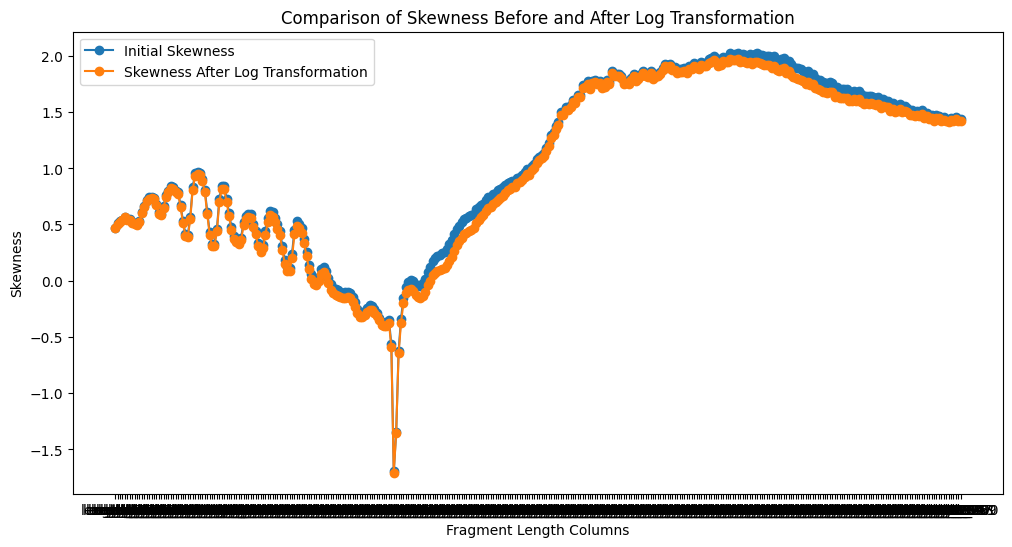

In [21]:
import scipy.stats as stats

# Generate a mock dataset for demonstration purposes with similar characteristics
# This dataset is non-normal, resembling fragment length frequencies with skewness
fragment_lengths = train_X_raw

# Calculate skewness before transformation
initial_skewness = fragment_lengths.apply(stats.skew)

# Apply log transformation to reduce skewness
log_transformed_data = np.log1p(fragment_lengths)

# Calculate skewness after transformation
transformed_skewness = log_transformed_data.apply(stats.skew)

# Plotting skewness before and after transformation for comparison
plt.figure(figsize=(12, 6))
plt.plot(initial_skewness, label='Initial Skewness', marker='o', linestyle='-')
plt.plot(transformed_skewness, label='Skewness After Log Transformation', marker='o', linestyle='-')
plt.xlabel('Fragment Length Columns')
plt.ylabel('Skewness')
plt.title('Comparison of Skewness Before and After Log Transformation')
plt.legend()
plt.show()

# Display initial and transformed skewness values in a DataFrame for easier comparison
skewness_comparison = pd.DataFrame({
    'Initial Skewness': initial_skewness,
    'Transformed Skewness': transformed_skewness
})


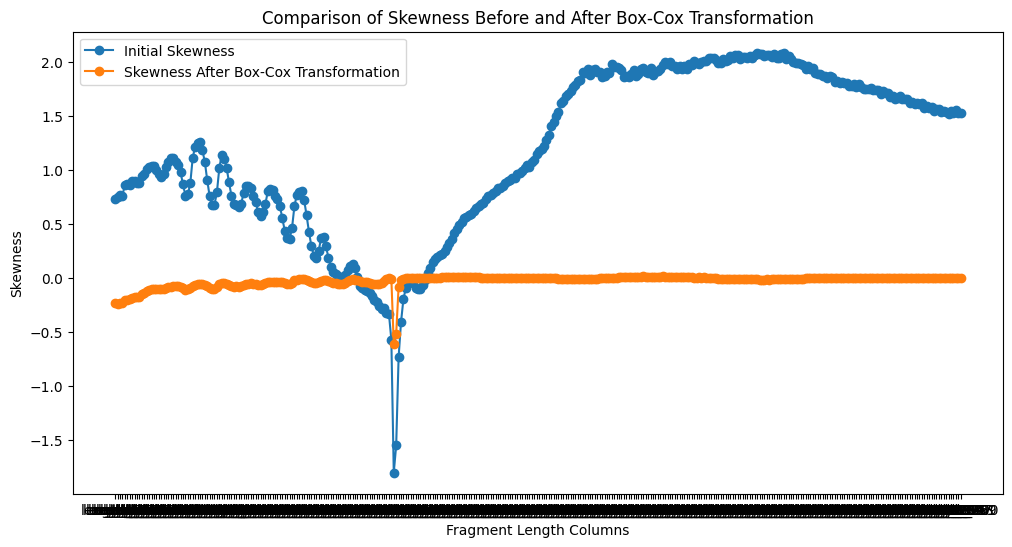

In [22]:
from scipy.stats import boxcox

# Combine train and test data for skewness analysis and transformation
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Select only numeric columns for skewness calculation
numeric_columns = combined_data.select_dtypes(include=[np.number])

# Calculate initial skewness before transformation
initial_skewness_combined = numeric_columns.apply(stats.skew)

# Apply Box-Cox transformation to each column if values are positive (Box-Cox requires positive values)
# Shift any zero or near-zero values slightly to be positive
boxcox_transformed_combined = numeric_columns.apply(lambda x: boxcox(x + 1e-6)[0] if (x > 0).all() else x, axis=0)

# Calculate skewness after Box-Cox transformation
boxcox_transformed_skewness_combined = boxcox_transformed_combined.apply(stats.skew)

# Plot skewness before and after Box-Cox transformation for comparison
plt.figure(figsize=(12, 6))
plt.plot(initial_skewness_combined, label='Initial Skewness', marker='o', linestyle='-')
plt.plot(boxcox_transformed_skewness_combined, label='Skewness After Box-Cox Transformation', marker='o', linestyle='-')
plt.xlabel('Fragment Length Columns')
plt.ylabel('Skewness')
plt.title('Comparison of Skewness Before and After Box-Cox Transformation')
plt.legend()
plt.show()

# Display initial and Box-Cox transformed skewness values in a DataFrame for easier comparison
boxcox_skewness_comparison_combined = pd.DataFrame({
    'Initial Skewness': initial_skewness_combined,
    'Box-Cox Transformed Skewness': boxcox_transformed_skewness_combined
})

# If needed to display the comparison table to the user in a tool
# import ace_tools as tools
# tools.display_dataframe_to_user(name="Box-Cox Skewness Comparison for Combined Data", dataframe=boxcox_skewness_comparison_combined)

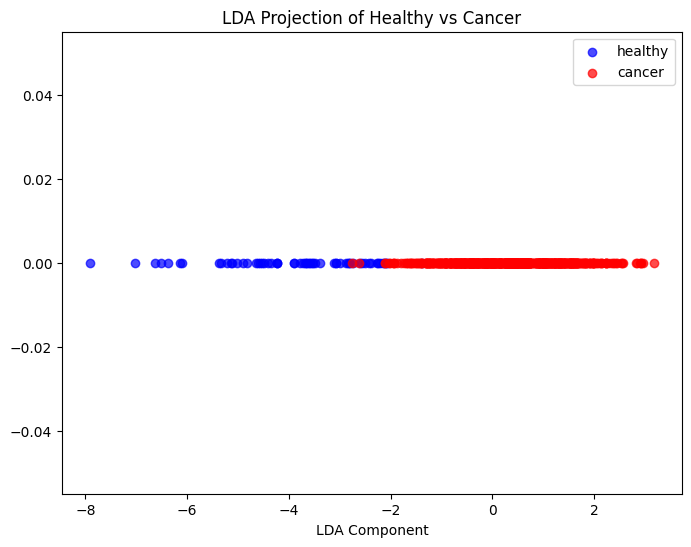

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Apply LDA -> separate
lda = LinearDiscriminantAnalysis(n_components=1)  # For binary classification, LDA can project down to 1D
X_lda = lda.fit_transform(train_X_scaled, train_y)

# Visualize the LDA result
plt.figure(figsize=(8, 6))
for label, color, l in zip([0, 1], ['blue', 'red'], ['healthy', 'cancer']):
    plt.scatter(X_lda[train_y == label], [0] * len(X_lda[train_y == label]), label=l, alpha=0.7, color=color)

plt.title('LDA Projection of Healthy vs Cancer')
plt.xlabel('LDA Component')
plt.legend()
plt.show()

In [24]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda.fit(train_X_scaled, train_y)

# Get the LDA coefficients (linear discriminants)
lda_coefficients = lda.coef_[0]

# Create a DataFrame to view the coefficients for each feature

feature_importance = pd.DataFrame({
    'Feature': train_X_raw.columns,
    'Coefficient': lda_coefficients
})

# Sort by the absolute value of the coefficient to find the most important features
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
important_features = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display the most important features
print(important_features.head(10))  # Top 10 most important features

        Feature  Coefficient  Abs_Coefficient
312  length_363   -99.689233        99.689233
314  length_365   -89.150719        89.150719
296  length_347   -85.433628        85.433628
84   length_135   -85.160699        85.160699
65   length_116   -82.845089        82.845089
85   length_136    82.085517        82.085517
281  length_332    78.225039        78.225039
144  length_195    77.263616        77.263616
301  length_352   -74.437919        74.437919
159  length_210   -73.862138        73.862138


# Machine Learning Models

## 01. Support Vector Machine

SVM was chosen as a classification model for our cancer dataset due to its effectiveness in handling high-dimensional data and its robustness against issues that arise from non-linear boundaries, which were apparent in our dataset.

Huang, M.-W., Chen, C.-W., Lin, W.-C., Ke, S.-W., & Tsai, C.-F. (2017). SVM and SVM Ensembles in Breast Cancer Prediction. PLOS ONE, 12(1), e0161501. https://doi.org/10.1371/journal.pone.0161501

In [25]:
# Importing relevant libraries
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

SVM model M1 will be fitted with data preprocessed by Near Miss, followed by PCA and LDA.
SVM model M2 will be fitted with data preprocessed by Near Miss, followed by LDA.
Dataset for each model is prepared accordingly.

In [26]:
# Preprocessing data
pca = PCA(n_components = 8)  #selection of 8 principal components
lda_m1 = LinearDiscriminantAnalysis(n_components = 1)
M1_train_X = pd.DataFrame(pca.fit_transform(X_NM), columns = pca_columns)
M1_test_X = pd.DataFrame(pca.transform(test_X_scaled), columns = pca_columns)
M1_train_X = lda_m1.fit_transform(M1_train_X, y_NM)
M1_test_X = lda_m1.transform(M1_test_X)

lda_m2 = LinearDiscriminantAnalysis(n_components = 1)
M2_train_X = lda_m2.fit_transform(X_NM, y_NM)
M2_test_X = lda_m2.transform(test_X_scaled)

y_train = y_NM

### M1 - SVM with data preprocessed by NearMiss - PCA - LDA

In [27]:
#M1 - SVM with data preprocessed by NearMIss then LDA

M1 = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)   #arbitrary gamma and C value is assigned

M1.fit(M1_train_X, y_train)
M1.pred = M1.predict(M1_test_X)

In [28]:
#M1 - Evaluation

# Calculate the confusion matrix
cm = confusion_matrix(test_y, M1.pred)

# Extracting True Positives, False Negatives, False Positives, and True Negatives
TN, FP, FN, TP = cm.ravel()

print(f"True Positives: {TP}")
print(f"False Negatives: {FN}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")

specificity = TN / (TN + FP)
print(f"Specificity: {specificity:.2f}")

print(classification_report(test_y, M1.pred))

True Positives: 130
False Negatives: 238
False Positives: 14
True Negatives: 27
Specificity: 0.66
              precision    recall  f1-score   support

           0       0.10      0.66      0.18        41
           1       0.90      0.35      0.51       368

    accuracy                           0.38       409
   macro avg       0.50      0.51      0.34       409
weighted avg       0.82      0.38      0.47       409



### M2 - SVM fit with data preprocessed by NearMiss - LDA

In [29]:
#M2 - SVM fit with data preprocessed by PCA

M2 = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)   #same hyperparameters as M1 are used for comparison

M2.fit(M2_train_X, y_train)
M2.pred = M2.predict(M2_test_X)

accuracy = accuracy_score(test_y, M2.pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 80.20%


In [30]:
# Calculate the confusion matrix
cm = confusion_matrix(test_y, M2.pred)

# Extracting True Positives, False Negatives, False Positives, and True Negatives
TN, FP, FN, TP = cm.ravel()

print(f"True Positives: {TP}")
print(f"False Negatives: {FN}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")

specificity = TN / (TN + FP)
print(f"Specificity: {specificity:.2f}")

print(classification_report(test_y, M2.pred))

True Positives: 300
False Negatives: 68
False Positives: 13
True Negatives: 28
Specificity: 0.68
              precision    recall  f1-score   support

           0       0.29      0.68      0.41        41
           1       0.96      0.82      0.88       368

    accuracy                           0.80       409
   macro avg       0.63      0.75      0.64       409
weighted avg       0.89      0.80      0.83       409



It is evident that M2 outperforms M1 - and now M2 will be optimized further by tuning the hyperparameters.

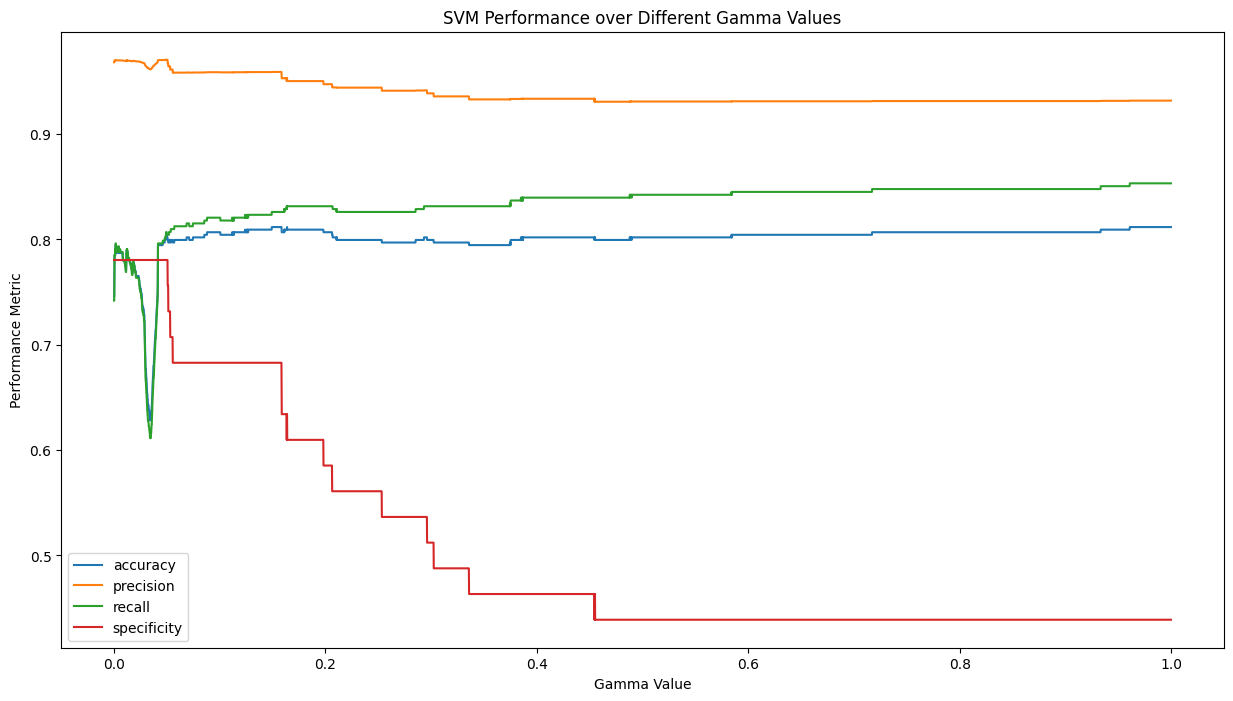

In [31]:
# Manual hyperparameter tuning - gamma
gamma = np.arange(1e-4, 1, 1e-4)  #range of gamma value to be tested
gamma_value_test = {}   #resultant metric stored in dictionary to be converted into dataframe
gamma_value_test['metrics'] = ['accuracy', 'precision', 'recall', 'specificity']   #labelling of metrics

for i in gamma:
    model = SVC(kernel = 'rbf', gamma = i, C = 1, random_state = 42)
    model.fit(M2_train_X, y_train)
    model.pred = model.predict(M2_test_X)
    cm = confusion_matrix(test_y, model.pred)
    TN, FP, FN, TP = cm.ravel()
    accuracy = accuracy_score(test_y, model.pred)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    gamma_value_test[i] = [accuracy, precision, recall, specificity]

gamma_value_test = pd.DataFrame(gamma_value_test)
gamma_value_test.set_index('metrics', inplace = True)

# plotting performance metrics over different gamma values
plt.figure(figsize = (15, 8))

for metric in gamma_value_test.index:
    plt.plot(gamma_value_test.columns, gamma_value_test.loc[metric], label = metric)

plt.xlabel("Gamma Value")
plt.ylabel("Performance Metric")
plt.title("SVM Performance over Different Gamma Values")
plt.legend()
plt.show()

Since specificity is only retained with a very small Gamma value, a second iteration is conducted to identify the local maxima of recall.

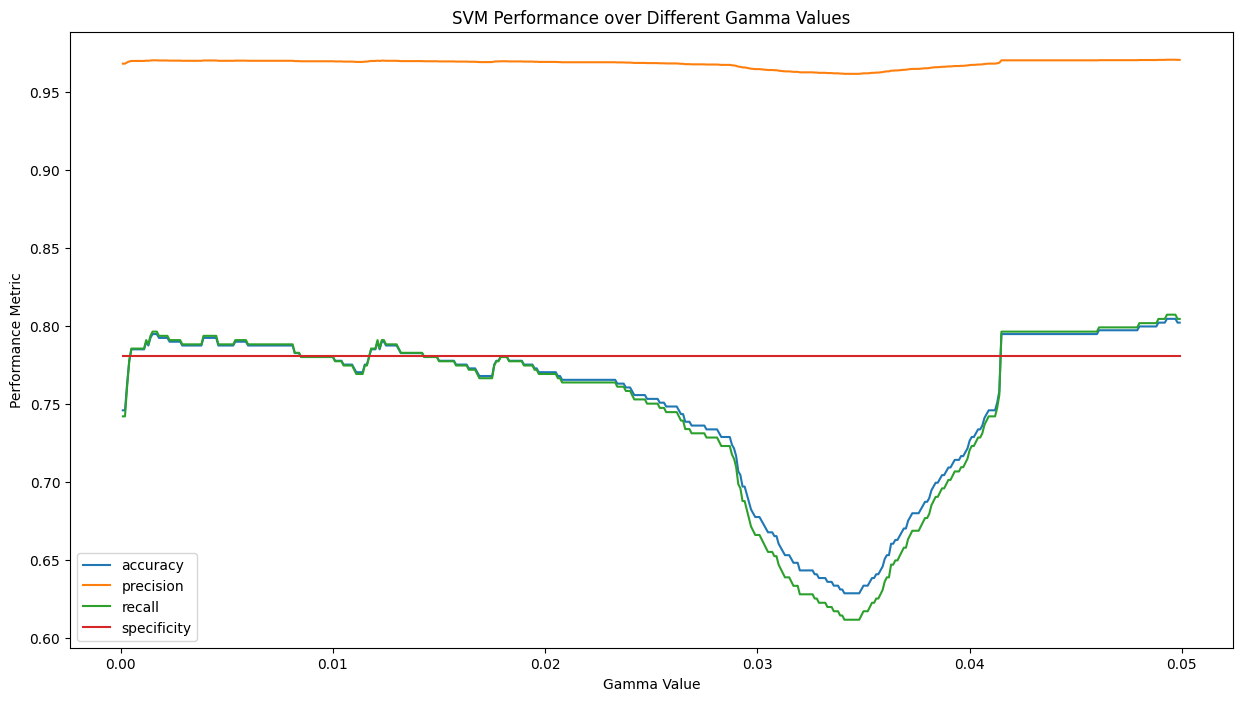

In [32]:
gamma = np.arange(1e-4, 0.05, 1e-4)
gamma_value_test = {}
gamma_value_test['metrics'] = ['accuracy', 'precision', 'recall', 'specificity']

for i in gamma:
    model = SVC(kernel = 'rbf', gamma = i, C = 1, random_state = 42)
    model.fit(M2_train_X, y_train)
    model.pred = model.predict(M2_test_X)
    cm = confusion_matrix(test_y, model.pred)
    TN, FP, FN, TP = cm.ravel()
    accuracy = accuracy_score(test_y, model.pred)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    gamma_value_test[i] = [accuracy, precision, recall, specificity]

gamma_value_test = pd.DataFrame(gamma_value_test)
gamma_value_test.set_index('metrics', inplace = True)

# plotting performance metrics over different gamma values
plt.figure(figsize = (15, 8))

for metric in gamma_value_test.index:
    plt.plot(gamma_value_test.columns, gamma_value_test.loc[metric], label = metric)

plt.xlabel("Gamma Value")
plt.ylabel("Performance Metric")
plt.title("SVM Performance over Different Gamma Values")
plt.legend()
plt.show()

In [33]:
recall_values = gamma_value_test.loc['recall']
gamma = recall_values.idxmax()
max_recall_value = recall_values.max()
print(gamma)

0.049300000000000004


Gamma = 0.0493

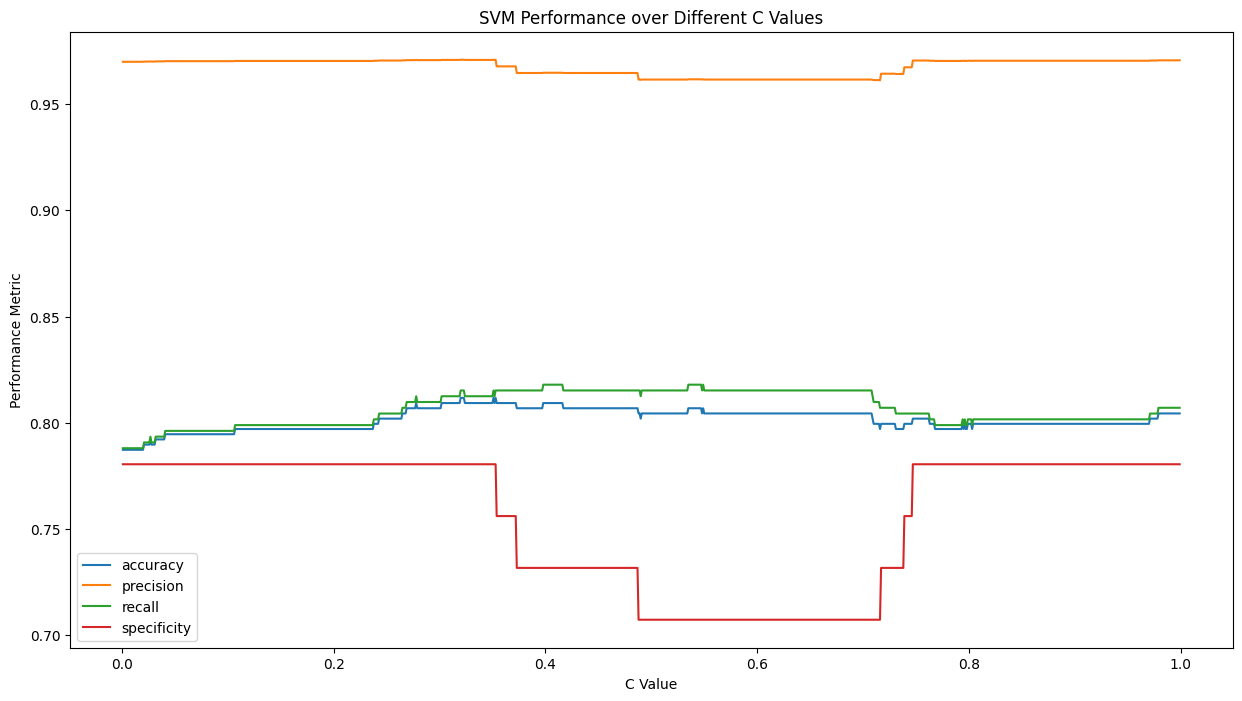

In [34]:
# Manual hyperparameter tuning - C
C = np.arange(1e-3, 1, 1e-3)
C_value_test = {}
C_value_test['metrics'] = ['accuracy', 'precision', 'recall', 'specificity']

for i in C:
    model = SVC(kernel = 'rbf', gamma = 0.0493, C = i, random_state = 42)
    model.fit(M2_train_X, y_train)
    model.pred = model.predict(M2_test_X)
    cm = confusion_matrix(test_y, model.pred)
    TN, FP, FN, TP = cm.ravel()
    accuracy = accuracy_score(test_y, model.pred)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    C_value_test[i] = [accuracy, precision, recall, specificity]

C_value_test = pd.DataFrame(C_value_test)
C_value_test.set_index('metrics', inplace = True)

plt.figure(figsize = (15, 8))

for metric in C_value_test.index:
    plt.plot(C_value_test.columns, C_value_test.loc[metric], label = metric)

plt.xlabel("C Value")
plt.ylabel("Performance Metric")
plt.title("SVM Performance over Different C Values")
plt.legend()
plt.show()

There is a peak of accuracy and recall observed around C = 0.3, which will be taken as the C value.

In [35]:
C_columns = [col for col in C_value_test.columns if 0.3 <= col <= 0.35]
recall_values_in_range = C_value_test.loc['recall', C_columns]
C = recall_values_in_range.idxmax()
local_max_recall_value = recall_values_in_range.max()
print(C)
print(local_max_recall_value)

0.32
0.8152173913043478


The finalised C value is 0.32

### M2 - Evaluation


In [36]:
M2 = SVC(kernel='rbf', gamma= 0.0493, C = 0.32, probability=True, random_state=42)

M2.fit(M2_train_X, y_train)
M2.pred = M2.predict(M2_test_X)

cm = confusion_matrix(test_y, M2.pred)

# Extracting True Positives, False Negatives, False Positives, and True Negatives
TN, FP, FN, TP = cm.ravel()

print(f"True Positives: {TP}")
print(f"False Negatives: {FN}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")

specificity = TN / (TN + FP)
print(f"Specificity: {specificity:.2f}")

print(classification_report(test_y, M2.pred))

True Positives: 300
False Negatives: 68
False Positives: 9
True Negatives: 32
Specificity: 0.78
              precision    recall  f1-score   support

           0       0.32      0.78      0.45        41
           1       0.97      0.82      0.89       368

    accuracy                           0.81       409
   macro avg       0.65      0.80      0.67       409
weighted avg       0.91      0.81      0.84       409



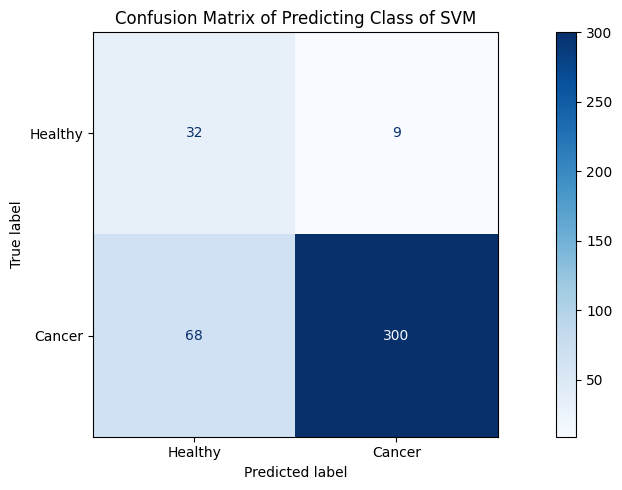

In [37]:
cm_svm = confusion_matrix(test_y, M2.pred)

fig, ax = plt.subplots(figsize=(12, 5))

disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot(ax=ax, cmap='Blues')
ax.set_title("Confusion Matrix of Predicting Class of SVM")
ax.set_xticklabels(['Healthy', 'Cancer'])
ax.set_yticklabels(['Healthy', 'Cancer'])

plt.tight_layout()
plt.show()

### Saving M2 as a pickle file

In [38]:
import os
import pickle

save_folder = '/content/drive/MyDrive/IT1244_Project/Model_Dataset'

model_path = os.path.join(save_folder, 'svm_model.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(M2, file)

print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/IT1244_Project/Model_Dataset/svm_model.pkl


## 02. Logistic Regression

In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_SM, y_SM, test_size=0.2, random_state=42)

# Before Tuning
lr_model = LogisticRegression(
    max_iter=5000,
    random_state=42,
    solver='saga',
    penalty='l2',
    C=1,
    tol=1e-5
)

# Cross-validation before tuning
cv_scores_before = cross_val_score(
    lr_model, X_SM, y_SM, cv=3, scoring='roc_auc', n_jobs=-1
)
print("Cross-Validation AUC-ROC Scores Before Tuning:", cv_scores_before)
print("Mean AUC-ROC Before Tuning:", cv_scores_before.mean())

# Fit on training set and evaluate on test set
lr_model.fit(X_train, y_train)
lr_pred_test_data = lr_model.predict(test_X_scaled)
print("\nAUC-ROC Score for Logistic Regression Before Tuning (Test):", roc_auc_score(test_y, lr_pred_test_data))
print("Classification Report Before Tuning (Test):\n", classification_report(test_y, lr_pred_test_data))

# Tuning with RandomizedSearchCV
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

X_sample = X_sample.replace([np.inf, -np.inf], np.nan).dropna()

# Define the parameter grid
lr_param_grid = [
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1],
        'solver': ['saga'],
        'max_iter': [2500, 2200],
        'tol': [1e-4]
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1],
        'solver': ['saga'],
        'max_iter': [2500, 2200],
        'tol': [1e-4],
        'l1_ratio': [0.2, 0.5, 0.8]
    }
]

logistic_model = LogisticRegression(random_state=42)

stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
lr_random_search = RandomizedSearchCV(
    estimator=logistic_model,
    param_distributions=lr_param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit StratifiedKFold
lr_random_search.fit(X_sample, y_sample)
lr_best_params = lr_random_search.best_params_
print("\nBest Hyperparameters from Logistic Regression Tuning:", lr_best_params)

# After Tuning
best_lr_model = LogisticRegression(
    random_state=42,
    **lr_best_params
)

# Cross-validation after tuning
cv_scores_after = cross_val_score(
    best_lr_model, X_SM, y_SM, cv=3, scoring='roc_auc', n_jobs=-1
)
print("Cross-Validation AUC-ROC Scores After Tuning:", cv_scores_after)
print("Mean AUC-ROC After Tuning:", cv_scores_after.mean())

# Final evaluation on test set
best_lr_model.fit(X_train, y_train)
best_lr_pred_test_data = best_lr_model.predict(test_X_scaled)
print("\nAUC-ROC Score for Logistic Regression After Tuning (Test):", roc_auc_score(test_y, best_lr_pred_test_data))
print("Classification Report After Tuning (Test):\n", classification_report(test_y, best_lr_pred_test_data))

Cross-Validation AUC-ROC Scores Before Tuning: [0.92920719 0.97279693 0.96443787]
Mean AUC-ROC Before Tuning: 0.955480665321514

AUC-ROC Score for Logistic Regression Before Tuning (Test): 0.8955461293743372
Classification Report Before Tuning (Test):
               precision    recall  f1-score   support

           0       0.53      0.88      0.66        41
           1       0.99      0.91      0.95       368

    accuracy                           0.91       409
   macro avg       0.76      0.90      0.80       409
weighted avg       0.94      0.91      0.92       409

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best Hyperparameters from Logistic Regression Tuning: {'tol': 0.0001, 'solver': 'saga', 'penalty': 'l2', 'max_iter': 2200, 'C': 1}
Cross-Validation AUC-ROC Scores After Tuning: [0.92615679 0.97060124 0.96218935]
Mean AUC-ROC After Tuning: 0.9529824601177386

AUC-ROC Score for Logistic Regression After Tuning (Test): 0.8941874337221632
Classification Report After Tuning (Test):
               precision    recall  f1-score   support

           0       0.52      0.88      0.65        41
           1       0.99      0.91      0.95       368

    accuracy                           0.91       409
   macro avg       0.75      0.89      0.80       409
weighted avg       0.94      0.91      0.92       409



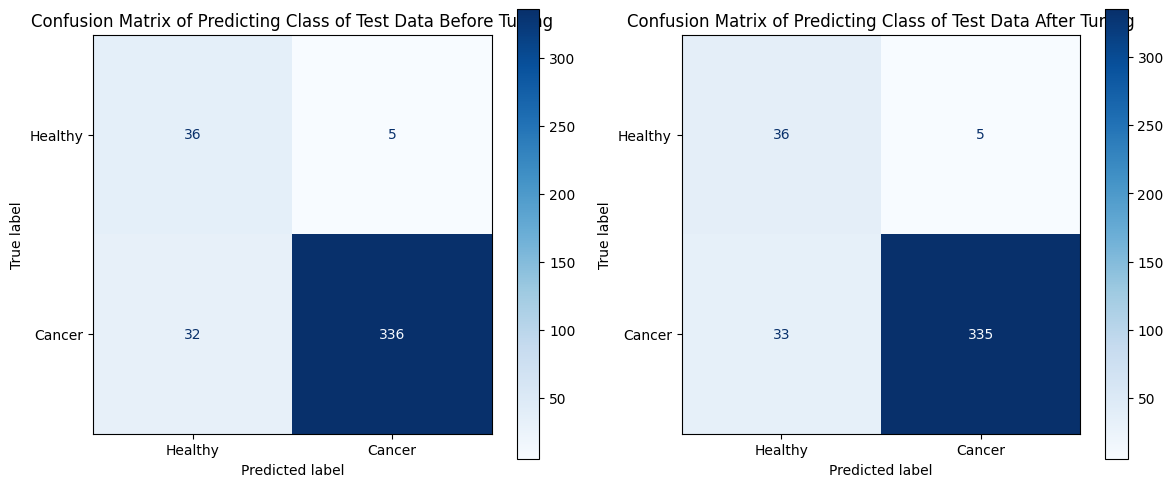

In [41]:
cm_before = confusion_matrix(test_y, lr_pred_test_data)
cm_after = confusion_matrix(test_y, best_lr_pred_test_data)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Confusion Matrix of Predicting Class of Test Data Before Tuning")
ax[0].set_xticklabels(['Healthy', 'Cancer'])
ax[0].set_yticklabels(['Healthy', 'Cancer'])

disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot(ax=ax[1], cmap='Blues')
ax[1].set_title("Confusion Matrix of Predicting Class of Test Data After Tuning")
ax[1].set_xticklabels(['Healthy', 'Cancer'])
ax[1].set_yticklabels(['Healthy', 'Cancer'])

plt.tight_layout()
plt.show()

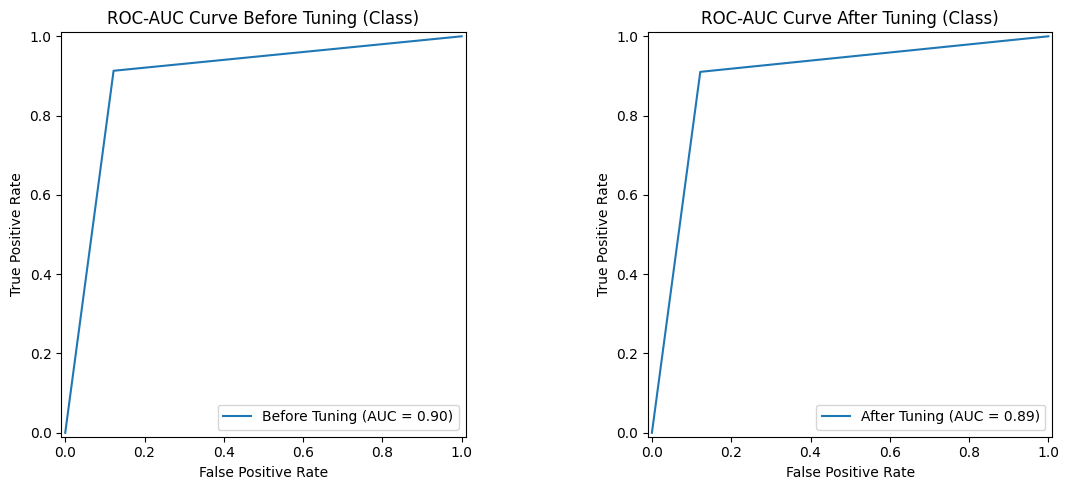

In [42]:
lr_fpr_before, lr_tpr_before, _ = roc_curve(test_y, lr_pred_test_data)
lr_roc_auc_before = auc(lr_fpr_before, lr_tpr_before)

lr_fpr_after, lr_tpr_after, _ = roc_curve(test_y, best_lr_pred_test_data)
lr_roc_auc_after = auc(lr_fpr_after, lr_tpr_after)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

display_before = RocCurveDisplay(fpr=lr_fpr_before, tpr=lr_tpr_before, roc_auc=lr_roc_auc_before, estimator_name='Before Tuning')
display_before.plot(ax=ax[0])
ax[0].set_title("ROC-AUC Curve Before Tuning (Class)")

display_after = RocCurveDisplay(fpr=lr_fpr_after, tpr=lr_tpr_after, roc_auc=lr_roc_auc_after, estimator_name='After Tuning')
display_after.plot(ax=ax[1])
ax[1].set_title("ROC-AUC Curve After Tuning (Class)")

plt.tight_layout()
plt.show()

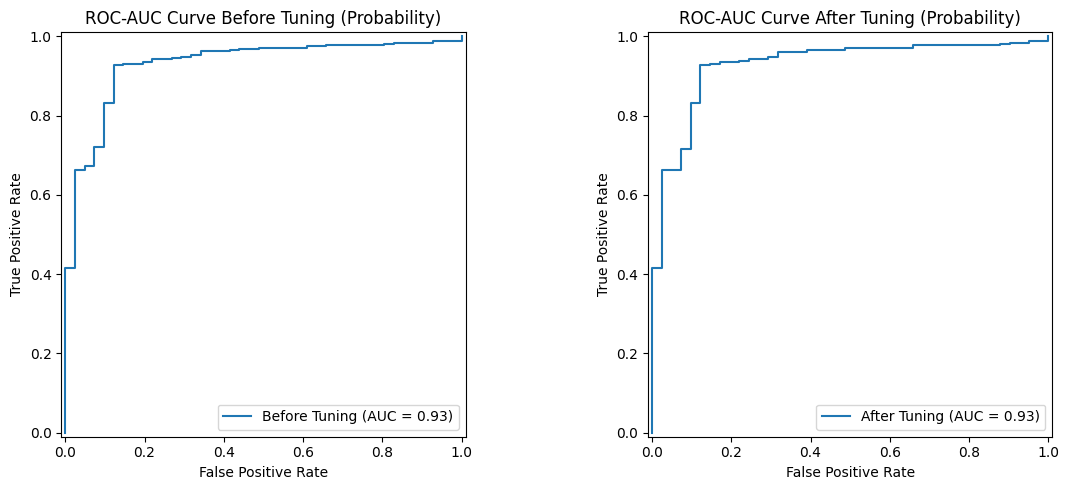

In [43]:
lr_fpr_before, lr_tpr_before, _ = roc_curve(test_y, lr_model.predict_proba(test_X_scaled)[:,1])
lr_roc_auc_before = auc(lr_fpr_before, lr_tpr_before)

lr_fpr_after, lr_tpr_after, _ = roc_curve(test_y, best_lr_model.predict_proba(test_X_scaled)[:,1])
lr_roc_auc_after = auc(lr_fpr_after, lr_tpr_after)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

display_before = RocCurveDisplay(fpr=lr_fpr_before, tpr=lr_tpr_before, roc_auc=lr_roc_auc_before, estimator_name='Before Tuning')
display_before.plot(ax=ax[0])
ax[0].set_title("ROC-AUC Curve Before Tuning (Probability)")

display_after = RocCurveDisplay(fpr=lr_fpr_after, tpr=lr_tpr_after, roc_auc=lr_roc_auc_after, estimator_name='After Tuning')
display_after.plot(ax=ax[1])
ax[1].set_title("ROC-AUC Curve After Tuning (Probability)")

plt.tight_layout()
plt.show()

In [44]:
import os
import pickle

save_folder = '/content/drive/MyDrive/IT1244_Project/Model_Dataset'

model_path = os.path.join(save_folder, 'logistic_model.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(best_lr_model, file)

print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/IT1244_Project/Model_Dataset/logistic_model.pkl


## 03. Voting Classifier

Tree-based models are well-suited for binary classification, by using a voting classifier composed of XGBoost, Random Forest, and Logistic Regression.

Alharbi, F., & Vakanski, A. (2023). Machine Learning Methods for Cancer Classification Using Gene Expression Data: A Review. Bioengineering, 10(2), 173. https://doi.org/10.3390/bioengineering10020173

Nguyen, M., Cao-Van, K., Minh, L. G., Bui, T. X., & Hong, S. (2024, October 2). Hybrid machine learning models using soft voting classifier for financial distress prediction. SSRN. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4941751

Before Tunning

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [46]:
X_train, X_val, y_train, y_val = train_test_split(X_SM, y_SM, test_size=0.2, random_state=42)

# XGBoost
xgb_model = XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    eta=0.2,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    eval_metric='auc',
    n_estimators=100,
    reg_lambda=1,
    reg_alpha=0,
    seed=42
)
xgb_model.fit(X_train, y_train)

# XGBoost predicts class on test data
xgb_pred_test_data = xgb_model.predict(test_X_scaled)
print("Test data Classification Report of XGBoost:\n", classification_report(test_y, xgb_pred_test_data))

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    random_state=42,
    bootstrap=True,
    n_jobs=-1,
)
rf_model.fit(X_train, y_train)

# Random Forest predicts class on test data
rf_pred_test_data = rf_model.predict(test_X_scaled)
print("Test data Classification Report of Random Forest:\n", classification_report(test_y, rf_pred_test_data))

# Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('xgb', xgb_model), ('rf', rf_model), ('lr', lr_model)],
    voting='soft',
    weights=[1, 1, 2]
)

voting_clf.fit(X_train, y_train)

voting_y_pred_train = voting_clf.predict(X_train)
voting_y_pred_val = voting_clf.predict(X_val)

voting_pred_test_data = voting_clf.predict(test_X_scaled)

print("Test data Classification Report of Voting Classifier:\n", classification_report(test_y, voting_pred_test_data))
print("AUC-ROC Score for Voting Classifier:", roc_auc_score(test_y, voting_pred_test_data))
print("AUC-ROC Score for XGBoost:", roc_auc_score(test_y, xgb_pred_test_data))
print("AUC-ROC Score for Logistic Regression:", roc_auc_score(test_y, lr_pred_test_data))
print("AUC-ROC Score for Random Forest:", roc_auc_score(test_y, rf_pred_test_data))

Test data Classification Report of XGBoost:
               precision    recall  f1-score   support

           0       0.37      0.63      0.47        41
           1       0.96      0.88      0.92       368

    accuracy                           0.86       409
   macro avg       0.66      0.76      0.69       409
weighted avg       0.90      0.86      0.87       409

Test data Classification Report of Random Forest:
               precision    recall  f1-score   support

           0       0.34      0.63      0.44        41
           1       0.95      0.86      0.91       368

    accuracy                           0.84       409
   macro avg       0.65      0.75      0.67       409
weighted avg       0.89      0.84      0.86       409

Test data Classification Report of Voting Classifier:
               precision    recall  f1-score   support

           0       0.52      0.83      0.64        41
           1       0.98      0.92      0.95       368

    accuracy                   

Tunning

In [47]:
# Tuning using RandomizedSearchCV
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, test_size=0.7, random_state=42)

# XGBoost
xgb_param_dist = {
    'eta': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7],
    'min_child_weight': [1, 2, 3, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'n_estimators': [50, 100, 200],
    'reg_lambda': [0, 1, 1.5],
    'reg_alpha': [0, 0.5, 1],
    'scale_pos_weight': [1, 2, 5]
}

xgb_model = XGBClassifier(random_state=42)
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
xgb_random_search.fit(X_sample, y_sample)
xgb_best_params = xgb_random_search.best_params_
print("Best Hyperparameters from XGBoost tuning:", xgb_best_params)

# Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
}

rf_model = RandomForestClassifier(random_state=42)
rf_random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=rf_param_grid,
    n_iter=12,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rf_random_search.fit(X_sample, y_sample)
rf_best_params = rf_random_search.best_params_
print("Best Hyperparameters from Random Forest tuning:", rf_best_params)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Hyperparameters from XGBoost tuning: {'subsample': 0.7, 'scale_pos_weight': 5, 'reg_lambda': 1.5, 'reg_alpha': 1, 'n_estimators': 100, 'min_child_weight': 2, 'max_depth': 5, 'eta': 0.3, 'colsample_bytree': 0.7}
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Hyperparameters from Random Forest tuning: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}


After Tunning

In [48]:
best_xgb_model = XGBClassifier(
    booster='gbtree',
    objective='binary:logistic',
    **xgb_best_params,
    eval_metric='auc',
    seed=42
)

best_lr_model = LogisticRegression(
    random_state=42,
    **lr_best_params
)

best_rf_model = RandomForestClassifier(
    random_state=42,
    **rf_best_params
)

best_voting_clf = VotingClassifier(
    estimators=[('xgb', best_xgb_model), ('rf', best_rf_model), ('lr', best_lr_model)],
    voting='soft',
    weights = [1, 1, 2]
)

# Cross-validation
cv_scores = cross_val_score(best_voting_clf, X_SM, y_SM, cv=5, scoring='roc_auc', n_jobs=-1)
print("Cross-Validation AUC-ROC Scores:", cv_scores)
print("Mean Cross-Validation AUC-ROC Score:", cv_scores.mean())

# Fit on train dataset
best_voting_clf.fit(X_train, y_train)

# Predict on test data
best_voting_pred_test_data = best_voting_clf.predict(test_X_scaled)

Cross-Validation AUC-ROC Scores: [0.98591377 0.98811857 0.99593195 0.98820677 0.9933021 ]
Mean Cross-Validation AUC-ROC Score: 0.9902946330984058


In [49]:
print("Classification Report After Tuning (Test):\n", classification_report(test_y, best_voting_pred_test_data))

Classification Report After Tuning (Test):
               precision    recall  f1-score   support

           0       0.58      0.80      0.67        41
           1       0.98      0.93      0.96       368

    accuracy                           0.92       409
   macro avg       0.78      0.87      0.81       409
weighted avg       0.94      0.92      0.93       409



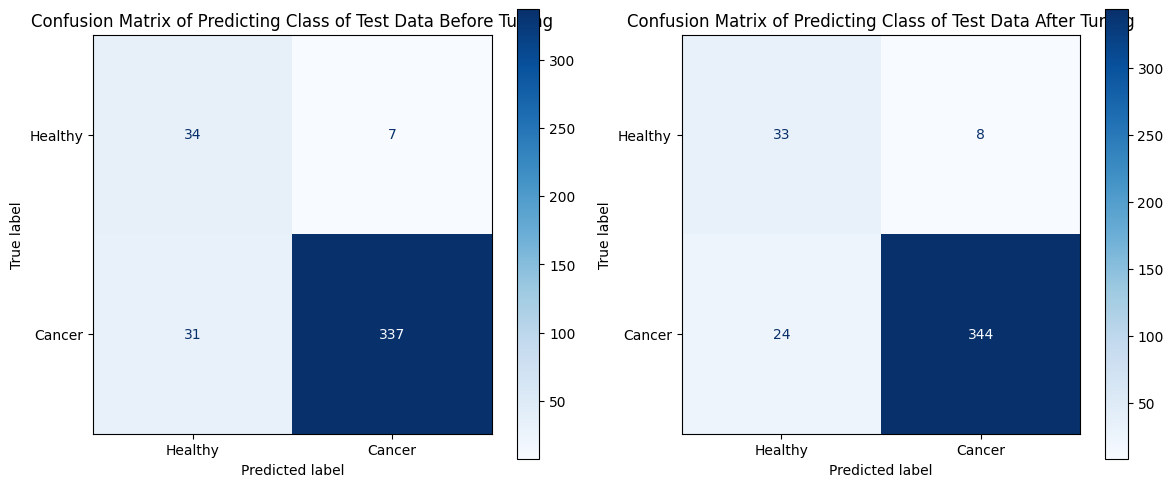

In [50]:
#Confusion Matrix
cm_before = confusion_matrix(test_y, voting_pred_test_data)
cm_after = confusion_matrix(test_y, best_voting_pred_test_data)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Confusion Matrix of Predicting Class of Test Data Before Tuning")
ax[0].set_xticklabels(['Healthy', 'Cancer'])
ax[0].set_yticklabels(['Healthy', 'Cancer'])


disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot(ax=ax[1], cmap='Blues')
ax[1].set_title("Confusion Matrix of Predicting Class of Test Data After Tuning")
ax[1].set_xticklabels(['Healthy', 'Cancer'])
ax[1].set_yticklabels(['Healthy', 'Cancer'])

plt.tight_layout()
plt.show()

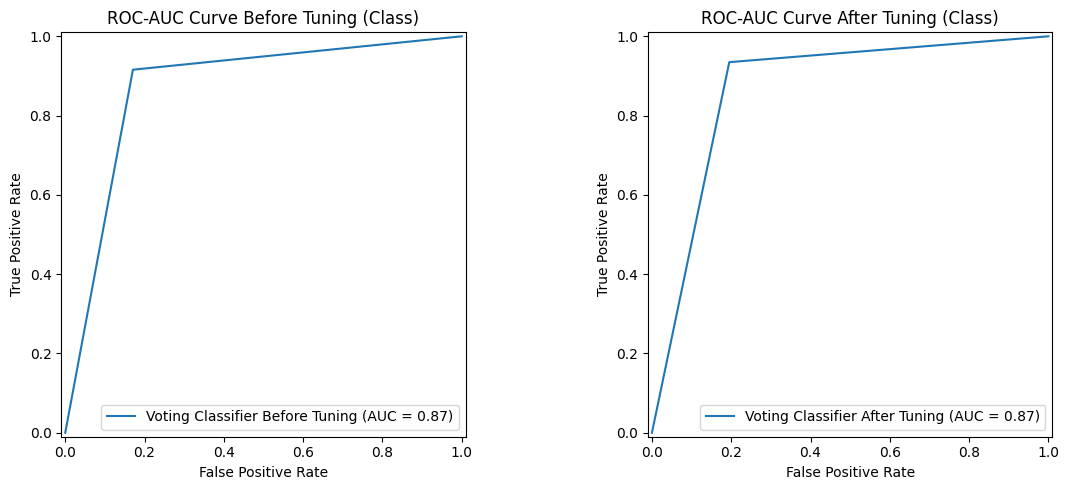

In [51]:
# ROC_AUC Curve
voting_fpr_before, voting_tpr_before, _ = roc_curve(test_y, voting_pred_test_data)
voting_roc_auc_before = auc(voting_fpr_before, voting_tpr_before)

voting_fpr_after, voting_tpr_after, _ = roc_curve(test_y, best_voting_pred_test_data)
voting_roc_auc_after = auc(voting_fpr_after, voting_tpr_after)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

display_before = RocCurveDisplay(fpr=voting_fpr_before, tpr=voting_tpr_before, roc_auc=voting_roc_auc_before, estimator_name='Voting Classifier Before Tuning')
display_before.plot(ax=ax[0])
ax[0].set_title("ROC-AUC Curve Before Tuning (Class)")

display_after = RocCurveDisplay(fpr=voting_fpr_after, tpr=voting_tpr_after, roc_auc=voting_roc_auc_after, estimator_name='Voting Classifier After Tuning')
display_after.plot(ax=ax[1])
ax[1].set_title("ROC-AUC Curve After Tuning (Class)")

plt.tight_layout()
plt.show()


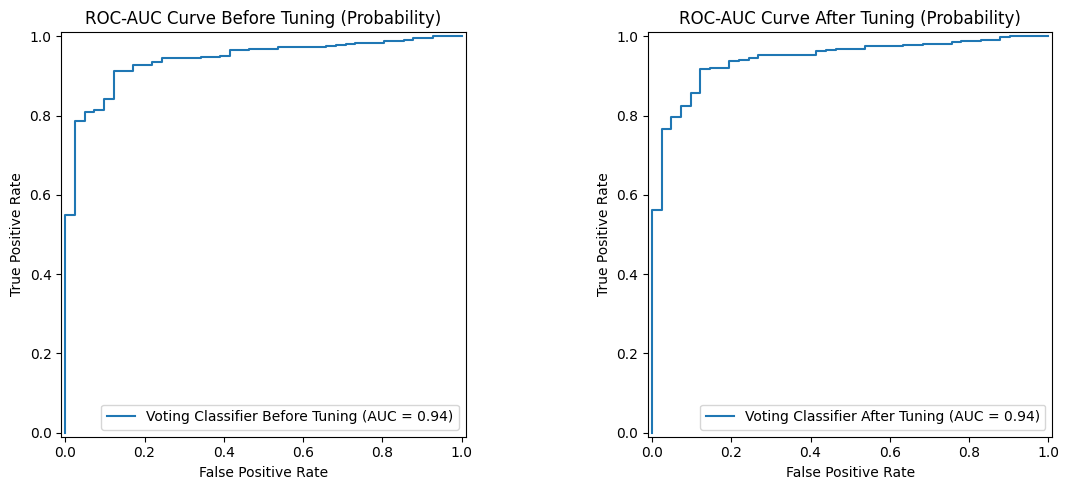

In [52]:
voting_fpr_before, voting_tpr_before, _ = roc_curve(test_y, voting_clf.predict_proba(test_X_scaled)[:,1])
voting_roc_auc_before = auc(voting_fpr_before, voting_tpr_before)

voting_fpr_after, voting_tpr_after, _ = roc_curve(test_y, best_voting_clf.predict_proba(test_X_scaled)[:,1])
voting_roc_auc_after = auc(voting_fpr_after, voting_tpr_after)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

display_before = RocCurveDisplay(fpr=voting_fpr_before, tpr=voting_tpr_before, roc_auc=voting_roc_auc_before, estimator_name='Voting Classifier Before Tuning')
display_before.plot(ax=ax[0])
ax[0].set_title("ROC-AUC Curve Before Tuning (Probability)")

display_after = RocCurveDisplay(fpr=voting_fpr_after, tpr=voting_tpr_after, roc_auc=voting_roc_auc_after, estimator_name='Voting Classifier After Tuning')
display_after.plot(ax=ax[1])
ax[1].set_title("ROC-AUC Curve After Tuning (Probability)")

plt.tight_layout()
plt.show()

In [53]:
import os
import pickle

save_folder = '/content/drive/MyDrive/IT1244_Project/Model_Dataset'

model_path = os.path.join(save_folder, 'voting_model.pkl')
with open(model_path, 'wb') as file:
    pickle.dump(best_voting_clf, file)

print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/IT1244_Project/Model_Dataset/voting_model.pkl


# 04. Perceptron

MLP classifiers have been designed for cancer classification in a line of prior works on gene expression analysis with high accuracy values. Our initial aim was to implement an MLP, but we decided on a perceptron after experimentation and tuning.

Alharbi, F., & Vakanski, A. (2023). Machine Learning Methods for Cancer Classification Using Gene Expression Data: A Review. Bioengineering, 10(2), 173. https://doi.org/10.3390/bioengineering10020173

In [54]:
# Dependencies for Keras and Numpy
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
print(keras.__version__)

3.4.1


In [55]:
X_train, X_val, y_train, y_val = train_test_split(train_X_scaled, train_y, random_state=42, test_size=0.2, stratify=train_y)

In [56]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Apply SMOTE to the entire training set
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)

minority_class = 0  # Assuming 0 is the minority class
original_minority_indices = np.where(y_train == minority_class)[0]

# Choose a subset of the original minority class data
subset_size = int(0.5 * len(original_minority_indices))
original_minority_subset = X_train.iloc[original_minority_indices[:subset_size]]
y_minority_subset = y_train.iloc[original_minority_indices[:subset_size]]

# Combine the SMOTE dataset with the original minority subset
X_train_balanced = np.concatenate((X_smote, original_minority_subset), axis=0)
y_train_balanced = np.concatenate((y_smote, y_minority_subset), axis=0)

# Shuffle the data
indices = np.random.permutation(len(X_train_balanced))
X_train_balanced, y_train_balanced = X_train_balanced[indices], y_train_balanced[indices]

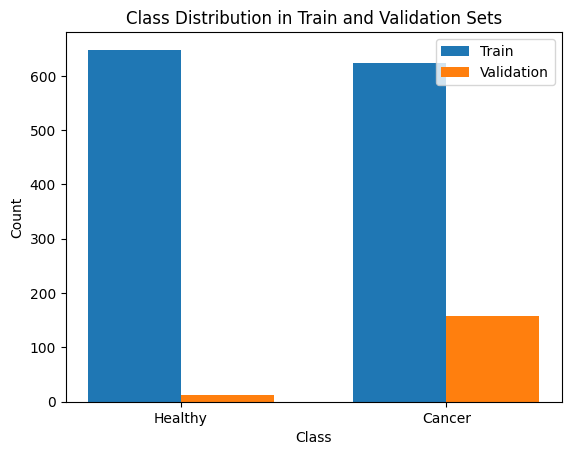

In [57]:
train_counts = np.bincount(y_train_balanced)
val_counts = np.bincount(y_val)

# Plotting
labels = ['Healthy', 'Cancer']
x = np.arange(len(labels))
fig, ax = plt.subplots()
bar_width = 0.35

# Bars for train and validation counts
train_bar = ax.bar(x - bar_width/2, train_counts, bar_width, label='Train')
val_bar = ax.bar(x + bar_width/2, val_counts, bar_width, label='Validation')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution in Train and Validation Sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Show the plot
plt.show()

In [58]:
model = keras.models.Sequential()
model.add(keras.layers.Input(shape=(350,)))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1)                   │             351 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 351 (1.37 KB)

 Trainable params: 351 (1.37 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
# compiling the model with loss function, optimizer and metrics
model.compile(loss="binary_crossentropy",
optimizer=keras.optimizers.Adam(),
metrics=[keras.metrics.Precision(name="prc"), keras.metrics.Recall(name="recall"), keras.metrics.AUC(name="auc")])

# training the model
history = model.fit(X_train_balanced, y_train_balanced, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - auc: 0.7049 - loss: 0.6467 - prc: 0.7094 - recall: 0.4749 - val_auc: 0.6115 - val_loss: 0.7517 - val_prc: 0.9444 - val_recall: 0.4331
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.7940 - loss: 0.5813 - prc: 0.8048 - recall: 0.5191 - val_auc: 0.6186 - val_loss: 0.7765 - val_prc: 0.9697 - val_recall: 0.4076
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8459 - loss: 0.5468 - prc: 0.8585 - recall: 0.5224 - val_auc: 0.6842 - val_loss: 0.7326 - val_prc: 0.9512 - val_recall: 0.4968
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8495 - loss: 0.5484 - prc: 0.8773 - recall: 0.4879 - val_auc: 0.6961 - val_loss: 0.7473 - val_prc: 0.9600 - val_recall: 0.4586
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8842 - loss: 0.5028 - prc: 0.9172 - recall: 0.5241 - val_auc: 0.7412 - val_loss: 0.7139 - val_prc: 0.9880 - val_recall: 0.5223
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8848 - los

In [60]:
# Saving the trained model
model.save('/content/drive/MyDrive/IT1244_Project/Model_Dataset/perceptron.h5')

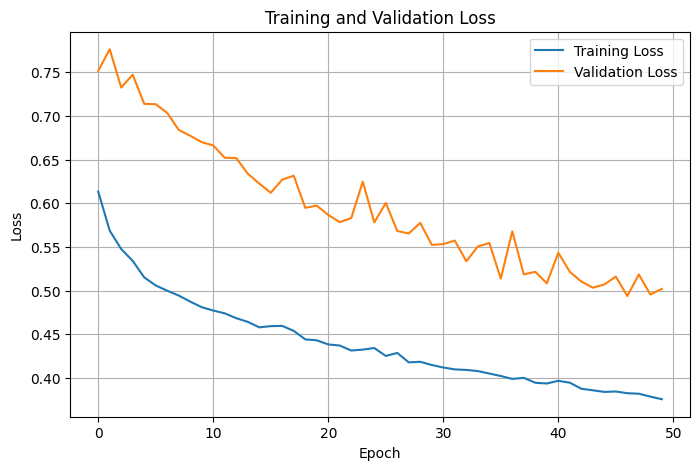

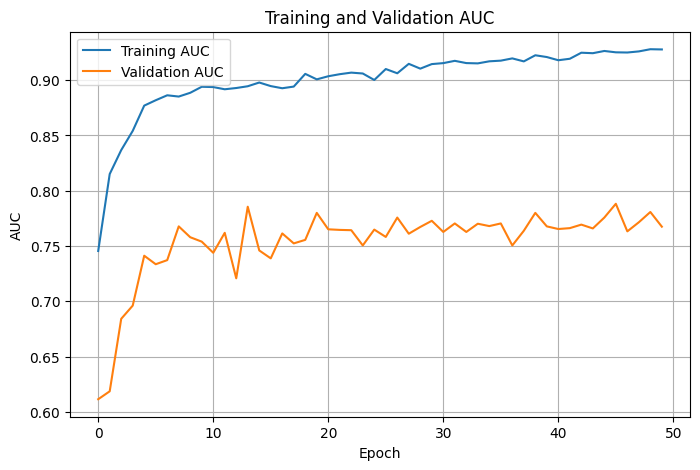

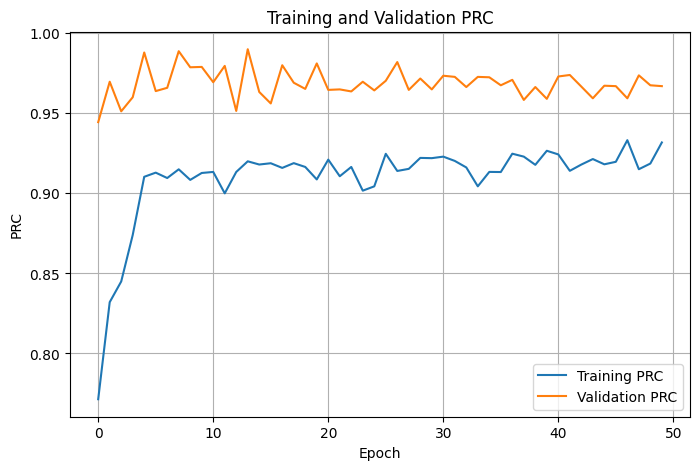

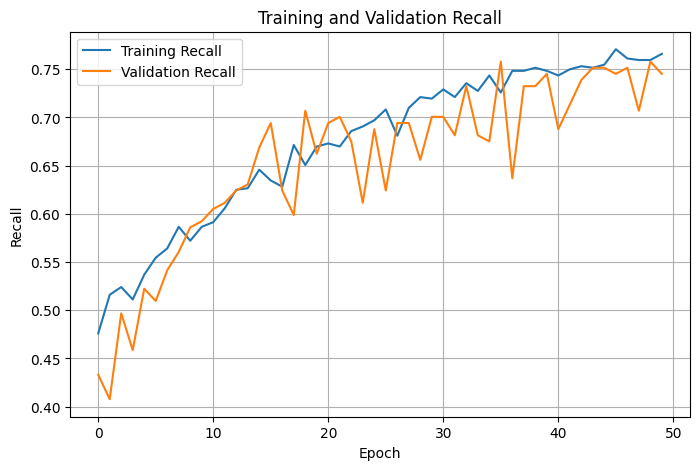

In [61]:
# Convert the training history to a DataFrame
history_df = pd.DataFrame(history.history)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot AUC (if needed)
if 'auc' in history_df.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(history_df['auc'], label='Training AUC')
    plt.plot(history_df['val_auc'], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Training and Validation AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

if 'prc' in history_df.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(history_df['prc'], label='Training PRC')
    plt.plot(history_df['val_prc'], label='Validation PRC')
    plt.xlabel('Epoch')
    plt.ylabel('PRC')
    plt.title('Training and Validation PRC')
    plt.legend()
    plt.grid(True)
    plt.show()

if 'recall' in history_df.columns:
    plt.figure(figsize=(8, 5))
    plt.plot(history_df['recall'], label='Training Recall')
    plt.plot(history_df['val_recall'], label='Validation Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Training and Validation Recall')
    plt.legend()
    plt.grid(True)
    plt.show()

In [62]:
model.evaluate(test_X_scaled, test_y)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.8010 - loss: 0.4682 - prc: 0.8524 - recall: 0.7467             


[0.5175416469573975,
 0.9697986841201782,
 0.7853260636329651,
 0.8492841720581055]

In [63]:
y_pred = model.predict(test_X_scaled)
y_pred = (y_pred > 0.5)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


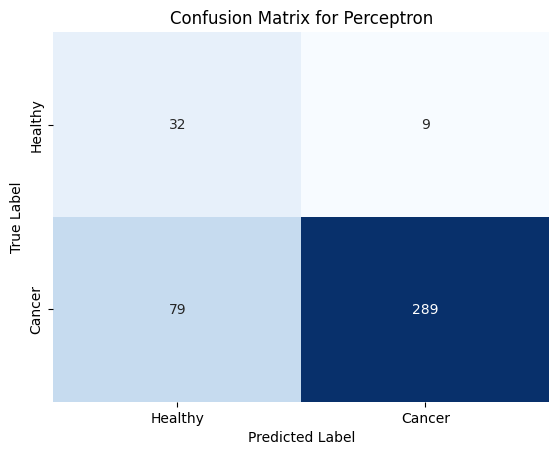

In [64]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, accuracy_score

# Assuming test_y and y_pred are already defined
cm = confusion_matrix(test_y, y_pred, labels=[0, 1])

# Create a heatmap for the confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Healthy', 'Cancer'],
            yticklabels=['Healthy', 'Cancer'])

plt.title('Confusion Matrix for Perceptron')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [65]:
tn, fp, fn, tp = cm.ravel()

tpr = tp / (tp + fn)
tnr = tn / (tn + fp)

print(f"True Positive Rate (TPR): {tpr:.2f}")
print(f"True Negative Rate (TNR): {tnr:.2f}")

True Positive Rate (TPR): 0.79
True Negative Rate (TNR): 0.78


In [66]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.29      0.78      0.42        41
           1       0.97      0.79      0.87       368

    accuracy                           0.78       409
   macro avg       0.63      0.78      0.64       409
weighted avg       0.90      0.78      0.82       409



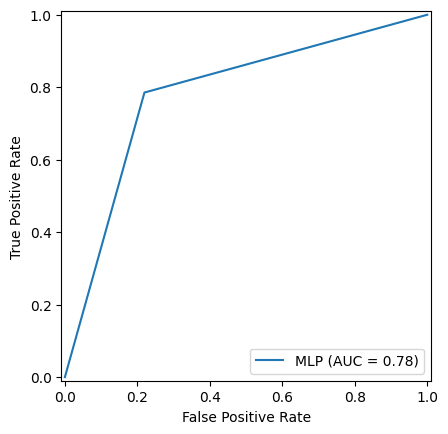

In [67]:
fpr, tpr, thresholds =roc_curve(test_y, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='MLP')
display.plot()
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC: 0.8490190880169671


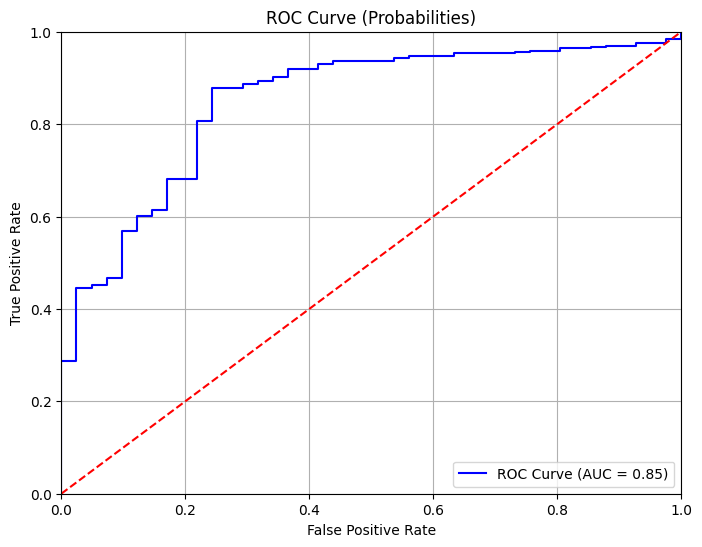

In [68]:
# Step 1: Predict probabilities on the test set
y_pred_probs_mlp = model.predict(test_X_scaled)

# Step 2: Calculate AUC
auc_value_mlp = roc_auc_score(test_y, y_pred_probs_mlp)
print(f"AUC: {auc_value_mlp}")

# Step 3: Plot ROC Curve
fpr_mlp, tpr_mlp, thresholds = roc_curve(test_y, y_pred_probs_mlp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_mlp, tpr_mlp, color='blue', label=f'ROC Curve (AUC = {auc_value_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Probabilities)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

The difference in AUC values could be due to how the predictions are being used in each case. This highlights that using a fixed threshold like 0.5 may not be optimal for evaluating model performance, as it does not capture the full range of possible decision thresholds.

Calculating AUC based on probability scores, rather than binary predictions, provides a more comprehensive assessment of the model's ability to distinguish between classes.

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


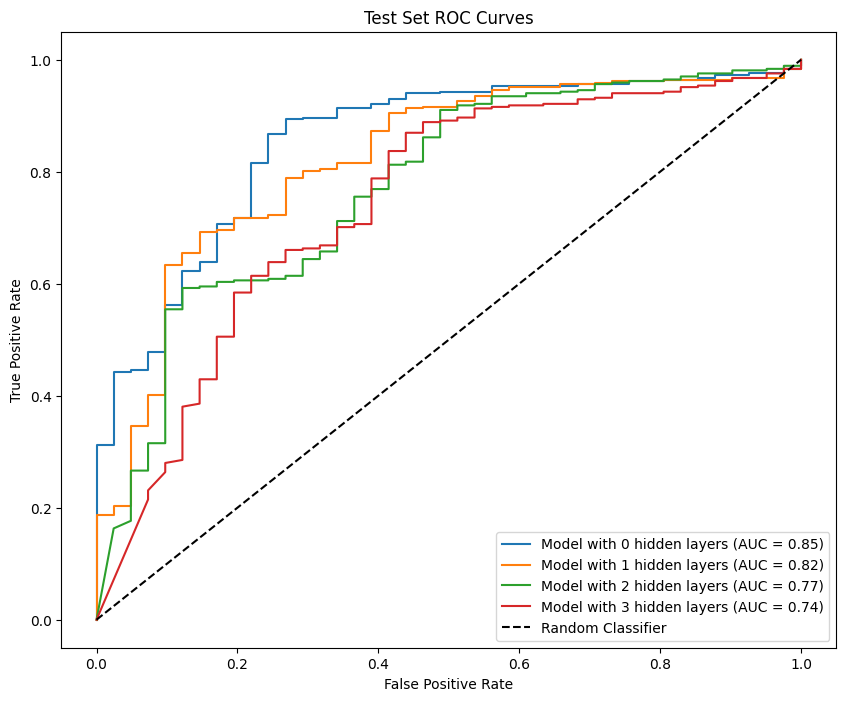

In [69]:
# Define your model training function
def build_and_train_model(hidden_layers, X_train, y_train, X_val, y_val):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(350,)))

    # Add hidden layers as per the configuration
    for _ in range(hidden_layers):
        model.add(keras.layers.Dense(64, activation="relu"))

    model.add(keras.layers.Dense(1, activation="sigmoid"))

    # Compile the model
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(),
        metrics=[keras.metrics.Precision(name="prc"), keras.metrics.Recall(name="recall"), keras.metrics.AUC(name="auc")]
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=False
    )

    return model, history

# Plot ROC curve for each model on the test set
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 8))
    for i, model in enumerate(models):
        y_pred_proba = model.predict(X_test).ravel()
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Model with {i} hidden layers (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test Set ROC Curves")
    plt.legend(loc="best")
    plt.show()

# Train models with 0, 1, 2, and 3 hidden layers
models = []
for hidden_layers in range(4):
    model, history = build_and_train_model(hidden_layers, X_train_balanced, y_train_balanced, X_val, y_val)
    models.append(model)

# Plot ROC curves on test data
plot_roc_curves(models, test_X_scaled, test_y)


Given the size of the dataset, a model with at most one dense layer achieves a good AUC score.

Other metrics were adjusted during model development, but extensive hyperparameter tuning was not considered necessary due to the data size and the tradeoff between performance and tuning complexity. Standard binary cross-entropy was used for binary classification, and the Adam optimizer.

With a larger dataset, however, an MLP could prove to be a more effective classifier.

# Performance

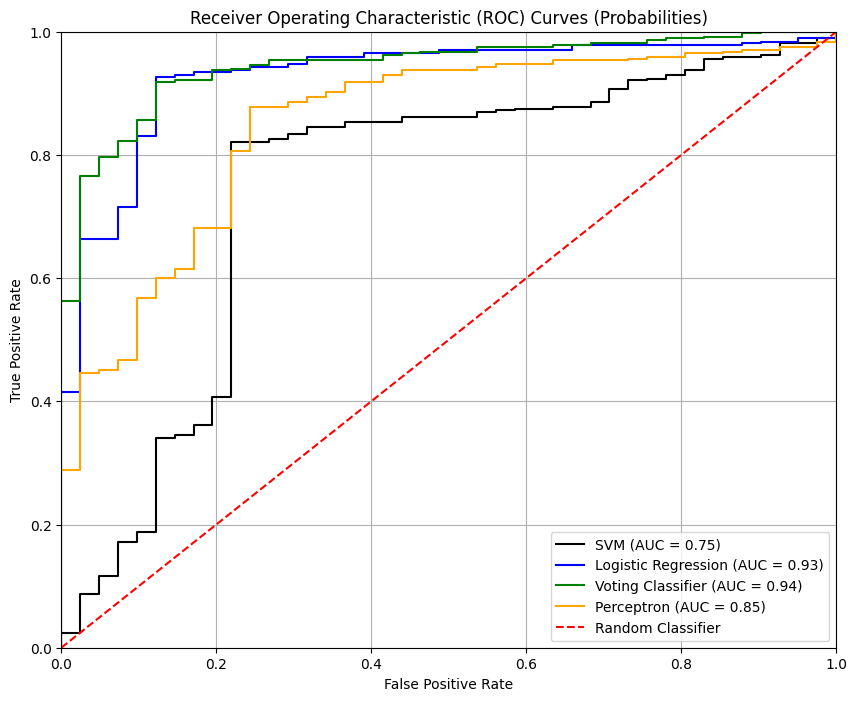

In [70]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

# Calculate ROC and AUC for SVM
svm_pred = M2.predict_proba(M2_test_X)
auc_value_svm = roc_auc_score(test_y,svm_pred[:,1])
fpr_svm, tpr_svm, thresholds_svm = roc_curve(test_y,svm_pred[:,1])

# Calculate ROC and AUC for MLP
auc_value_mlp = roc_auc_score(test_y, y_pred_probs_mlp)
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(test_y, y_pred_probs_mlp)

# Plot all ROC curves in one figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_svm, tpr_svm, color='black', label=f'SVM (AUC = {auc_value_svm:.2f})')
plt.plot(lr_fpr_after, lr_tpr_after, color='blue', label=f'Logistic Regression (AUC = {lr_roc_auc_after:.2f})')
plt.plot(voting_fpr_after, voting_tpr_after, color='green', label=f'Voting Classifier (AUC = {voting_roc_auc_after:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='orange', label=f'Perceptron (AUC = {auc_value_mlp:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves (Probabilities)')
plt.legend(loc='lower right')
plt.grid()
plt.show()